# Skin lesion classification

**Deadline**: Upload this notebook (rename it as 'TP-SVM-YOUR-SURNAME.ipynb') to Ecampus/Moodle before the deadline.
Complete the code where you see XXXXXXXXXXXXXXXXX (mandatory for everybody)

**Context**
A skin lesion is defined as a superficial growth or patch of the skin that is visually different and/or has a different texture than its surrounding area. Skin lesions, such as moles or birthmarks, can degenerate and become melanoma, one of the deadliest skin cancer. Its incidence has been increasing during the last decades, especially in the areas mostly populated by white people.

The most effective treatment is an early detection followed by surgical excision. This is why several approaches for melanoma detection have been proposed in the last years (non-invasive computer-aided diagnosis (CAD) ).


**Goal**
The goal of this practical session is to classify images of skin lesions as either benign or melanoma using machine learning algorithms. In order to do that, you will have at your disposal a set of 30 features already extracted from 600 dermoscopic images (both normal skin lesions and melanoma from the ISIC database - https://isic-archive.com/). These features characterize the Asymmetry, the Border irregularity, the Colour and the Dimension of the lesion (the so-called ABCD rule).

The features are:
- shape asimmetry (f0 and f1)
- difference in colors between center and periphery of the image (f2, f3, f4, f27, f28, f29)
- geometry (f5, f6, f7)
- other features related to eccentricity,entropy, mean, standard deviation and maximum value of each channel in RGB and HSV (f8,...,f24)
- asimmetry of color intensity (f25, f26)

Features are computed using *manually checked segmentations* and following *Ganster et al. 'Automated melanoma recognition', IEEE TMI, 2001* and *Zortea et al. 'Performance of a dermoscopy-based computer vision system for the diagnosis of pigmented skin lesions compared with visual evaluation by experienced dermatologists', Artificial Intelligence in Medicine, 2014*.

First load all necessary packages

In [14]:
import os
import numpy as np
import pandas as pd
from skimage.io import imread
from time import time
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  cross_val_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, KFold, cross_validate
from sklearn.linear_model import Perceptron
from sklearn.decomposition import PCA

%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

try:
  import google.colab
  IN_COLAB = True
  print('You are using Google Colab')
  !pip install googledrivedownloader
  from googledrivedownloader import download_file_from_google_drive
except:
  IN_COLAB = False

# Code from scikit-learn
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


from sklearn.pipeline import make_pipeline

You are using Google Colab


Then load the data from my Google Drive

In [15]:
if IN_COLAB:
  download_file_from_google_drive(file_id='18hrQVGBCfW7SKTnzmWUONo8iowBsi1DL',
  dest_path='./data/features.csv')
  download_file_from_google_drive(file_id='1iQZdUiuK_FwZ7mik7LB3eN_H_IUc5l7b',
  dest_path='./data/im/nevus-seg.jpg')
  download_file_from_google_drive(file_id='1_TeYzLLDoKbPX4xXAOAM_mQiT2nLHgvp',
  dest_path='./data/im/nevus.jpg')
  download_file_from_google_drive(file_id='1B2Ol92mBcHN6ah3bpoucBbBbHkPMGC8D',
  dest_path='./data/im/melanoma-seg.jpg')
  download_file_from_google_drive(file_id='1yZ46UzGhwO7g5T8397JpewBl6UqgRo5J',
  dest_path='./data/im/melanoma.jpg')

Or from yout local computer. Please download the 'data' folder in the same folder as your notebook and do not modifiy it.

Then read the data

In [16]:
## Read data
Working_directory="./data/"
df = pd.read_csv(Working_directory + 'features.csv') # reading data
y = df['Malignant'].values # 1 for Melanoma and 0 for healthy
class_names = ["healthy","melanoma"]
X = df.iloc[:,3:33].values # Features
N,M=X.shape
print('Number of images: {0}; Number of features per image: {1}'.format(N,M))
print('Number of healthy nevus: {0}; Number of melanoma: {1}'.format(N-np.sum(y), np.sum(y)))


Number of images: 600; Number of features per image: 30
Number of healthy nevus: 485; Number of melanoma: 115


Two examples of healthy nevus and melanoma


Text(0.5, 1.0, 'Segmented melanoma')

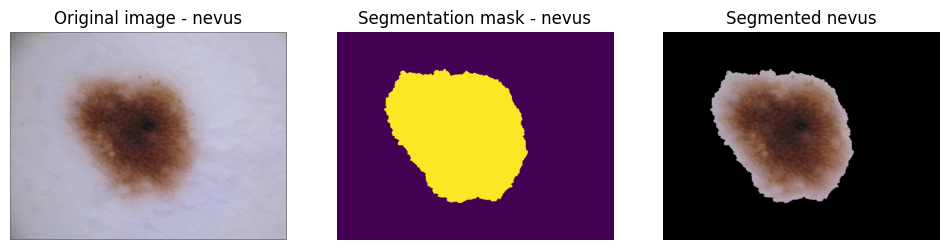

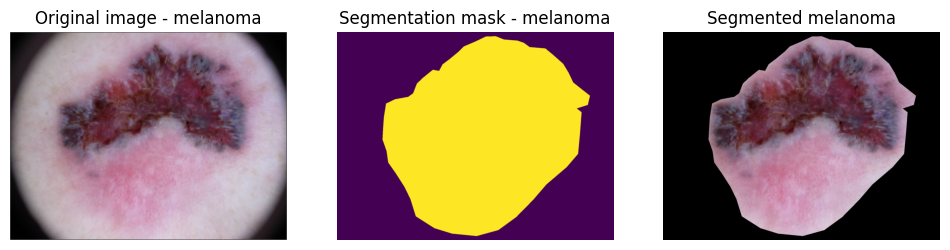

In [17]:
## Plot two examples of nevus and melanoma
print('Two examples of healthy nevus and melanoma')
nevus = imread(Working_directory + 'im/nevus.jpg')
nevus_Segmentation = imread(Working_directory + 'im/nevus-seg.jpg')
nevus_Segmentation_boolean = (nevus_Segmentation/255).astype(np.uint8) # To get uint8 (integer numbers)
nevus_Segmentation_3D = np.expand_dims(nevus_Segmentation_boolean, axis=2) # To have a binary mask for the three channels (RGB)
nevus_mul_mask = (nevus_Segmentation_3D*nevus) # we apply the binary mask to all channels pixel-wise

fig = plt.figure(figsize=(12, 12)) # size of the figure
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5) # code to create subplots
grid[0].imshow(nevus)
grid[0].axis('off')
grid[0].set_title('Original image - nevus')
grid[1].imshow(nevus_Segmentation)
grid[1].axis('off')
grid[1].set_title("Segmentation mask - nevus")
grid[2].imshow(nevus_mul_mask)
grid[2].axis('off')
grid[2].set_title("Segmented nevus")

###

melanoma = imread(Working_directory + 'im/melanoma.jpg')
melanoma_Segmentation = imread(Working_directory + 'im/melanoma-seg.jpg')
melanoma_Segmentation_boolean = (melanoma_Segmentation/255).astype(np.uint8) # To get uint8 (integer numbers)
melanoma_Segmentation_3D = np.expand_dims(melanoma_Segmentation_boolean, axis=2) # To have a binary mask for the three channels (RGB)
melanoma_mul_mask = (melanoma_Segmentation_3D*melanoma) # we apply the binary mask to all channels pixel-wise

fig = plt.figure(figsize=(12, 12)) # size of the figure
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5) # code to create subplots
grid[0].imshow(melanoma)
grid[0].axis('off')
grid[0].set_title('Original image - melanoma')
grid[1].imshow(melanoma_Segmentation)
grid[1].axis('off')
grid[1].set_title("Segmentation mask - melanoma")
grid[2].imshow(melanoma_mul_mask)
grid[2].axis('off')
grid[2].set_title("Segmented melanoma")


Now, as in the previous practical session you should shuffle the data randomly

In [18]:
# Shuffle data randomly
indeces= np.arange(N)
np.random.shuffle(indeces)

Xp=X[indeces]
yp=y[indeces]

We should now test the discriminative power of our features. Fist, let divide the entire data-set into training and test set using the `stratify` option. This will preserve the original proportion between nevus and melanoma also in the training and test set. You can check that from the plot.

Text(0, 0.5, 'Proportion')

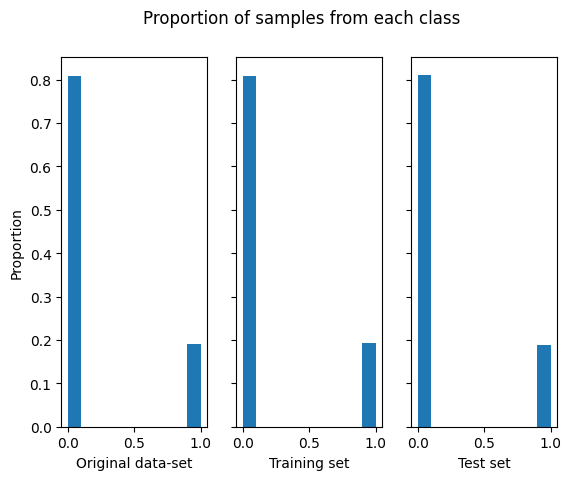

In [19]:
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(Xp, yp, test_size=0.3, random_state=42,stratify=yp)

fig, axs = plt.subplots(1, 3, sharey=True)
fig.suptitle('Proportion of samples from each class')
axs[0].hist(yp,weights=np.ones_like(yp)/len(yp))
axs[0].set_xlabel('Original data-set')
axs[1].hist(y_train,weights=np.ones_like(y_train)/len(y_train))
axs[1].set_xlabel('Training set')
axs[2].hist(y_test,weights=np.ones_like(y_test)/len(y_test))
axs[2].set_xlabel('Test set')
axs[0].set_ylabel('Proportion')

As we have already seen, it might be very important to scale the data such that each feature has, for instance, average equal to 0 and unit variance. Which is the right way of doing it when having a training and a test set in your opinion ? Should you use together both training and test set ? (For simplicity's sake, we will restrict here to scaling all features).

In [20]:
# Scale data (each feature will have average equal to 0 and unit variance)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scale=scaler.transform(X_train)
X_test_scale=scaler.transform(X_test)

Now, use two simple classification algorithms, for instance LDA and QDA, and look at the confusion matrices.

**Question**: Comment the results.

Both results are not good, particularly the one achieved with QDA, as they have extremely high false negatives.

Fitting LDA to training set
              precision    recall  f1-score   support

           0       0.84      0.95      0.89       146
           1       0.50      0.24      0.32        34

    accuracy                           0.81       180
   macro avg       0.67      0.59      0.61       180
weighted avg       0.78      0.81      0.78       180

Normalized confusion matrix
[[0.94520548 0.05479452]
 [0.76470588 0.23529412]]


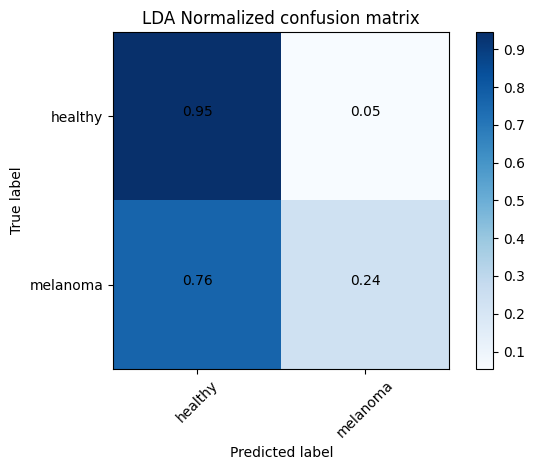

----------------------------------------------------------------------------------
Fitting QDA to training set
              precision    recall  f1-score   support

           0       0.82      0.96      0.89       146
           1       0.40      0.12      0.18        34

    accuracy                           0.80       180
   macro avg       0.61      0.54      0.53       180
weighted avg       0.74      0.80      0.75       180

Normalized confusion matrix
[[0.95890411 0.04109589]
 [0.88235294 0.11764706]]


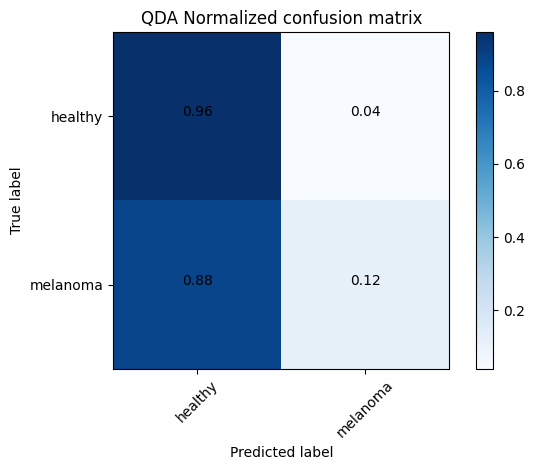

In [21]:
# Fitting LDA
print("Fitting LDA to training set")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scale, y_train)
y_pred = lda.predict(X_test_scale)
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='LDA Normalized confusion matrix')
plt.show()

print("----------------------------------------------------------------------------------")

# Fitting QDA

print("Fitting QDA to training set")
t0 = time()
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_scale, y_train)
y_pred = qda.predict(X_test_scale)
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='QDA Normalized confusion matrix')
plt.show()


The results you obtained are based on a precise subdivision of your data into training and test. This can thus bias your results. Which technique could you use instead ? Test it  with LDA, QDA and K-NN.

We could use cross-validation

In [22]:
# Fitting LDA
print("Fitting LDA")

t0 = time()
lda = LinearDiscriminantAnalysis()
lda_score = cross_val_score(lda,X=X_train_scale, y=y_train,cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))

print("")
# Fitting QDA
print("Fitting QDA")
t0 = time()
qda = QuadraticDiscriminantAnalysis()
qda_score = cross_val_score(qda,X=X_train_scale, y=y_train,cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(qda_score.mean(), qda_score.std() ))

# Fitting K-nearest neighbour

print("Fitting K-nearest neighbour")
t0 = time()
neigh = KNeighborsClassifier(n_neighbors=3)
neigh_score = cross_val_score(neigh,X=X_train_scale, y=y_train,cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(neigh_score.mean(), neigh_score.std() ))

Fitting LDA
done in 0.082s
 Average and std CV score : 0.8023809523809524 +- 0.02208004403689453

Fitting QDA
done in 0.054s
 Average and std CV score : 0.8047619047619048 +- 0.036576884513660035
Fitting K-nearest neighbour
done in 0.046s
 Average and std CV score : 0.7904761904761904 +- 0.03809523809523809


---
When using K-NN, instead than fixing the number of nearest neighbours, we could also estimate the best value using Cross Validation.

**Question** Do it and plot the confusion matrix. Do you notice anything strange ? Why in your opinion do you have this kind of result ?

---

Although the labeling of healthy images was satisfactory, the amount of misclassification of melanoma images is allarming. This issue with false-negatives may be due to the difference in the proportion of healthy images to images with a melanoma, making the metric criteria accuracy inappropriate.

dict_keys(['memory', 'steps', 'transform_input', 'verbose', 'standardscaler', 'kneighborsclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])
Best training Score: 0.8238095238095238
Best training params: {'kneighborsclassifier__n_neighbors': 10}
Normalized confusion matrix
[[0.97260274 0.02739726]
 [0.85294118 0.14705882]]


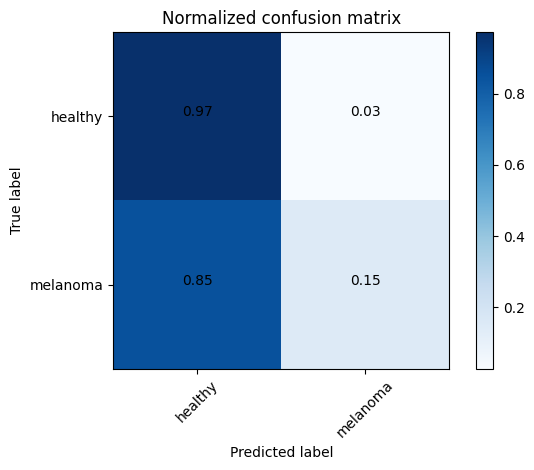

In [23]:
# Looking for the best hyperparameters
neigh = make_pipeline(StandardScaler(), KNeighborsClassifier())
# when using the pipeline, you can print the parameters of the estimator using print(neigh.get_params().keys())`
print(neigh.get_params().keys())
p_grid_KNN = {'kneighborsclassifier__n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
grid_KNN = GridSearchCV(estimator=neigh, param_grid=p_grid_KNN, scoring="accuracy", cv=5)
grid_KNN.fit(X_train, y_train)
print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
y_pred = grid_KNN.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In order to deal with this problem we have two possible solutions.

**First**: Please look at this webpage (https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) and try MORE APPROPRIATE scoring functions than accuracy when looking for the best K value of K-NN (thus within the Cross Validation as before..).

**Answer**

The best result was achieved with the metrics recall, although the proportion of false negatives is still high

dict_keys(['memory', 'steps', 'transform_input', 'verbose', 'standardscaler', 'kneighborsclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])
Best training Score: -1.0748137779057774
Best training params: {'kneighborsclassifier__n_neighbors': 10}
Normalized confusion matrix
[[0.97260274 0.02739726]
 [0.85294118 0.14705882]]


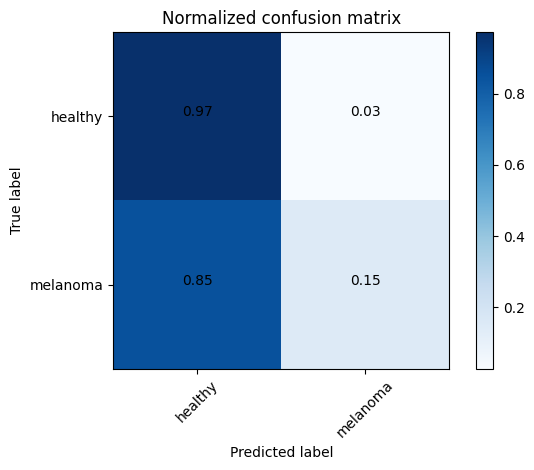

In [28]:
# Looking for the best hyperparameters
# Looking for the best hyperparameters
neigh = make_pipeline(StandardScaler(), KNeighborsClassifier())
# when using the pipeline, you can print the parameters of the estimator using print(neigh.get_params().keys())`
print(neigh.get_params().keys())
p_grid_KNN = {'kneighborsclassifier__n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
grid_KNN = GridSearchCV(estimator=neigh, param_grid=p_grid_KNN, scoring="recall", cv=5)
grid_KNN.fit(X_train, y_train)
print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
y_pred = grid_KNN.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

**Second**: when dealing with such a problem (the one you should find !) a possible solution would be to oversample a class (which one in your opinion ?) Please look at this web page for more information (https://imbalanced-learn.org/stable/over_sampling.html) and try at least the ADASYN over-sampling strategy (look at the following code...).

NB: if you want to use the naive random oversampling (i.e. randomly sampling with replacement) be careful not to have the same sample both in the training and validation (or test) set during cross-validation (or testing). This would be considered as a data-leakage.

In [25]:
from imblearn.over_sampling import ADASYN
from collections import Counter
ros = ADASYN(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))

[(np.int64(0), 339), (np.int64(1), 335)]


Let's look for the best K in KNN (as before using Cross validation) but this time on the new training set.

**Question**: Are the results better ? Do they change now if you modify the scoring function ? Why ?

The results are much better. Now, at least the amount of false negatives is close to 0.5, even if this is still not good.

dict_keys(['memory', 'steps', 'transform_input', 'verbose', 'standardscaler', 'kneighborsclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])
Best training Score: 0.8792309632804534
Best training params: {'kneighborsclassifier__n_neighbors': 2}
              precision    recall  f1-score   support

           0       0.85      0.84      0.84       146
           1       0.35      0.38      0.37        34

    accuracy                           0.75       180
   macro avg       0.60      0.61      0.61       180
weighted avg       0.76      0.75      0.75       180

Normalized confusion matrix
[[0.83561644 0.16438356]
 [0.61764706 0.38235294]]


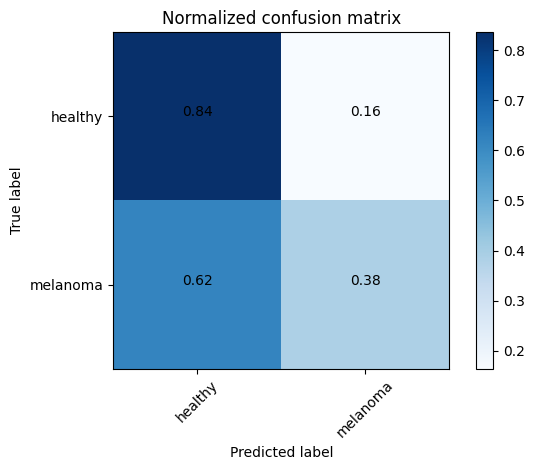

In [29]:
# Looking for the best hyperparameters
# Looking for the best hyperparameters
neigh = make_pipeline(StandardScaler(), KNeighborsClassifier())
# when using the pipeline, you can print the parameters of the estimator using print(neigh.get_params().keys())`
print(neigh.get_params().keys())
p_grid_KNN = {'kneighborsclassifier__n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
grid_KNN = GridSearchCV(estimator=neigh, param_grid=p_grid_KNN, scoring="f1", cv=5)
grid_KNN.fit(X_resampled, y_resampled)
print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
y_pred = grid_KNN.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Let's use the techniques seen today: Perceptron and linear SVM.

In [30]:
# Fitting Perceptron
print("Fitting Perceptron")
Perc = make_pipeline(StandardScaler(), Perceptron())
Perc_cv = cross_validate(Perc,Xp, yp,cv=5,scoring='accuracy',return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_score'].mean(), Perc_cv['train_score'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_score'].mean(), Perc_cv['test_score'].std() ))


# Fitting linear SVM on original data
print("Fitting Linear SVM")
Lsvm = make_pipeline(StandardScaler(), LinearSVC())
Lsvm_cv = cross_validate(Lsvm,Xp, yp,cv=5,scoring='accuracy',return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_score'].mean(), Lsvm_cv['train_score'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_score'].mean(), Lsvm_cv['test_score'].std() ))

Fitting Perceptron
 Average and std TRAIN CV accuracy : 0.7837500000000001 +- 0.0337577151675485
 Average and std TEST CV accuracy : 0.7533333333333333 +- 0.03597838857487153
Fitting Linear SVM
 Average and std TRAIN CV accuracy : 0.845 +- 0.008395600699837464
 Average and std TEST CV accuracy : 0.825 +- 0.026874192494328514


We can easily use different scoring functions within the cross validate function of scikit-learn. Check the code.

In [31]:
# Fitting Perceptron
print("Fitting Perceptron")
Perc = make_pipeline(StandardScaler(), Perceptron())
Perc_cv = cross_validate(Perc,Xp, yp,cv=5,scoring=('accuracy', 'f1'),return_train_score=True)
print(Perc_cv.keys())
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_accuracy'].mean(), Perc_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_accuracy'].mean(), Perc_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Perc_cv['train_f1'].mean(), Perc_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Perc_cv['test_f1'].mean(), Perc_cv['test_f1'].std() ))


# Fitting linear SVM on original data
print("Fitting Linear SVM")
Lsvm = make_pipeline(StandardScaler(), LinearSVC())
Lsvm_cv = cross_validate(Lsvm,Xp, yp,cv=5,scoring=('accuracy', 'f1'),return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_accuracy'].mean(), Lsvm_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_accuracy'].mean(), Lsvm_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Lsvm_cv['train_f1'].mean(), Lsvm_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Lsvm_cv['test_f1'].mean(), Lsvm_cv['test_f1'].std() ))


Fitting Perceptron
dict_keys(['fit_time', 'score_time', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.7837500000000001 +- 0.0337577151675485
 Average and std TEST CV accuracy : 0.7533333333333333 +- 0.03597838857487153
 Average and std TRAIN CV f1 : 0.35881029810298104 +- 0.12075882577502138
 Average and std TEST CV f1 : 0.2902977806507218 +- 0.09817031081550635
Fitting Linear SVM
 Average and std TRAIN CV accuracy : 0.845 +- 0.008395600699837464
 Average and std TEST CV accuracy : 0.825 +- 0.026874192494328514
 Average and std TRAIN CV f1 : 0.4228346079846079 +- 0.046416343283592516
 Average and std TEST CV f1 : 0.35732658654859795 +- 0.0754796718951872


**Question** Please do the same on the oversampled data and compare the results with the previous ones. Please note that here you should use the ‘make_pipeline‘ function of Imbalanced scikit-learn. You can look here:  [LINK](https://imbalanced-learn.org/stable/references/generated/imblearn.pipeline.make_pipeline.html)


In [32]:
from imblearn.pipeline import make_pipeline as make_pipeline2

# Fitting Perceptron
print("Fitting Perceptron")
Perc = make_pipeline2(ADASYN(random_state=0),StandardScaler(), Perceptron())
Perc_cv = cross_validate(Perc,Xp, yp, cv=5,scoring=('accuracy', 'f1'),return_train_score=True)
print(Perc_cv.keys())
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_accuracy'].mean(), Perc_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_accuracy'].mean(), Perc_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Perc_cv['train_f1'].mean(), Perc_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Perc_cv['test_f1'].mean(), Perc_cv['test_f1'].std() ))


#fitting Linear SVM
print("Fitting Linear SVM")
Lsvm = make_pipeline2(ADASYN(random_state=0),StandardScaler(), LinearSVC())
Lsvm_cv = cross_validate(Lsvm,Xp, yp,cv=5,scoring=('accuracy', 'f1'),return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_accuracy'].mean(), Lsvm_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_accuracy'].mean(), Lsvm_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Lsvm_cv['train_f1'].mean(), Lsvm_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Lsvm_cv['test_f1'].mean(), Lsvm_cv['test_f1'].std() ))

Fitting Perceptron
dict_keys(['fit_time', 'score_time', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.6345833333333333 +- 0.046614554236489955
 Average and std TEST CV accuracy : 0.6083333333333334 +- 0.06749485577105531
 Average and std TRAIN CV f1 : 0.4246377548637573 +- 0.026233220482930416
 Average and std TEST CV f1 : 0.37766161675678234 +- 0.04203569298468219
Fitting Linear SVM
 Average and std TRAIN CV accuracy : 0.7541666666666667 +- 0.015645819462932146
 Average and std TEST CV accuracy : 0.7066666666666667 +- 0.02494438257849293
 Average and std TRAIN CV f1 : 0.5180954651083864 +- 0.020651628559086574
 Average and std TEST CV f1 : 0.4272468581016094 +- 0.05674724709206195


We can also ask to save the estimated models at each split (i.e. fold) with the option `return_estimator=True`. Using the perceptron, we will look for the best model using the oversampled training data and check the confusion matrix on the test data.
In that case, we will need to first split the data into train/test and then do the oversampling ONLY in the train data.

**Question** Do it the same with the linear SVM.

Fitting Perceptron
dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.6738095238095237 +- 0.0880992598824572
 Average and std TEST CV accuracy : 0.6285714285714286 +- 0.037191665123365046
 Average and std TRAIN CV f1 : 0.4247970434665048 +- 0.09101932997986541
 Average and std TEST CV f1 : 0.32183899195688753 +- 0.046401608266473146
Normalized confusion matrix
[[0.78767123 0.21232877]
 [0.44117647 0.55882353]]


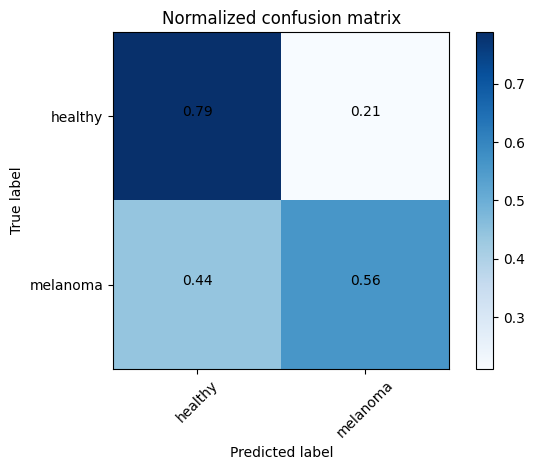

Fitting Linear SVM
 Average and std TRAIN CV accuracy : 0.7803571428571429 +- 0.02246185983823001
 Average and std TEST CV accuracy : 0.7095238095238094 +- 0.038832158167381156
 Average and std TRAIN CV f1 : 0.5642847779188729 +- 0.025990144423172615
 Average and std TEST CV f1 : 0.42877106162365963 +- 0.061995507477543545
Normalized confusion matrix
[[0.7260274 0.2739726]
 [0.5       0.5      ]]


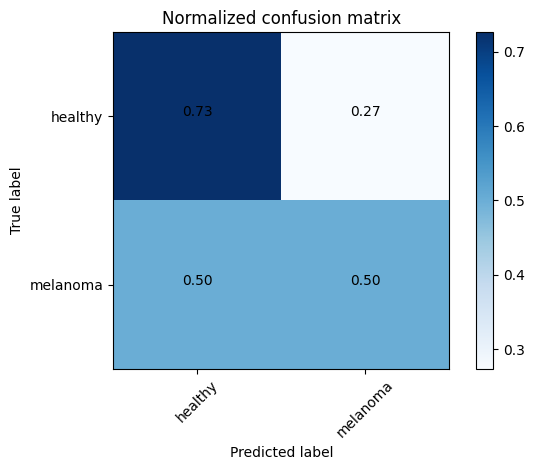

In [35]:
# Fitting Perceptron
print("Fitting Perceptron")
Perc = make_pipeline2(ADASYN(random_state=0),StandardScaler(), Perceptron())
Perc_cv = cross_validate(Perc,X_train, y_train,cv=5,scoring=('accuracy', 'f1'),return_train_score=True,return_estimator=True)
print(Perc_cv.keys())
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_accuracy'].mean(), Perc_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_accuracy'].mean(), Perc_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Perc_cv['train_f1'].mean(), Perc_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Perc_cv['test_f1'].mean(), Perc_cv['test_f1'].std() ))

# Look for the best estimator (the one with the greatest test accuracy)
index_best = np.argmax(Perc_cv['test_accuracy'])
estimator_best=Perc_cv['estimator'][index_best]
y_pred = estimator_best.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()


# Fitting linear SVM

print("Fitting Linear SVM")
Lsvm = make_pipeline2(ADASYN(random_state=0), StandardScaler(), LinearSVC())
Lsvm_cv = cross_validate(Lsvm, X_train, y_train, cv=5, scoring=('accuracy', 'f1'), return_train_score=True, return_estimator=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_accuracy'].mean(), Lsvm_cv['train_accuracy'].std()))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_accuracy'].mean(), Lsvm_cv['test_accuracy'].std()))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Lsvm_cv['train_f1'].mean(), Lsvm_cv['train_f1'].std()))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Lsvm_cv['test_f1'].mean(), Lsvm_cv['test_f1'].std()))

# Look for the best estimator (the one with the greatest test accuracy)
index_best = np.argmax(Lsvm_cv['test_accuracy'])
estimator_best = Lsvm_cv['estimator'][index_best]
y_pred = estimator_best.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Suppose that there are overlapping classes, we need to set the hyper-parameter C for the SVM model.

**Question** Use Cross-Validation on the oversampled data to find the best C value. Plot the confusion matrix using the best estimator (as before).

Best training Score: 0.7357142857142858
Best training parameter: 0.001
              precision    recall  f1-score   support

           0       0.88      0.78      0.83       146
           1       0.37      0.56      0.45        34

    accuracy                           0.74       180
   macro avg       0.63      0.67      0.64       180
weighted avg       0.79      0.74      0.76       180

Normalized confusion matrix
[[0.78082192 0.21917808]
 [0.44117647 0.55882353]]


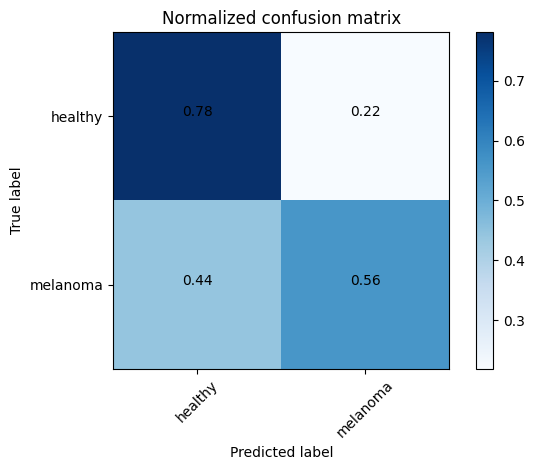

In [37]:
# Looking for the best hyperparameter C
Lsvm = make_pipeline2(ADASYN(random_state=0),StandardScaler(), LinearSVC())
p_grid_lsvm = {'linearsvc__C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1]}
grid_lsvm = GridSearchCV(estimator=Lsvm, param_grid=p_grid_lsvm, scoring="accuracy", cv=5, return_train_score=True)
grid_lsvm.fit(X_train, y_train)

# Look for the best estimator (the one with the greatest test accuracy)
best_estimator = grid_lsvm.best_estimator_
y_pred = best_estimator.predict(X_test)
print("Best training Score: {}".format(grid_lsvm.best_score_))
print("Best training parameter: {}".format(grid_lsvm.best_params_['linearsvc__C']))


print(classification_report(y_test, y_pred))
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,title='Normalized confusion matrix')
plt.show()

Best training Score: 0.5816176470588236
Best training parameter: 0.1
              precision    recall  f1-score   support

           0       0.87      0.78      0.82       146
           1       0.35      0.50      0.41        34

    accuracy                           0.73       180
   macro avg       0.61      0.64      0.62       180
weighted avg       0.77      0.73      0.75       180

Normalized confusion matrix
[[0.78082192 0.21917808]
 [0.5        0.5       ]]


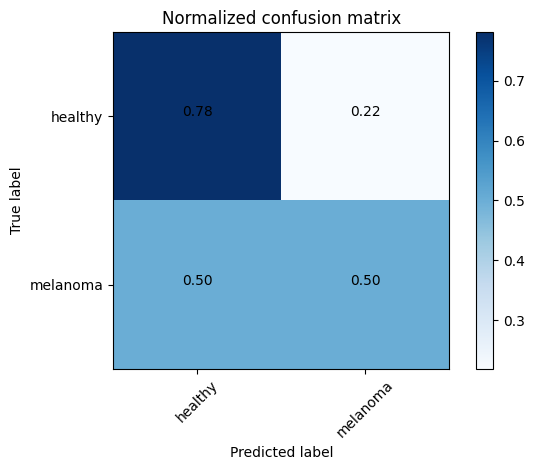

In [41]:
# Looking for the best hyperparameter C
Lsvm = make_pipeline2(ADASYN(random_state=0),StandardScaler(), LinearSVC())
p_grid_lsvm = {'linearsvc__C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1]}
grid_lsvm = GridSearchCV(estimator=Lsvm, param_grid=p_grid_lsvm, scoring="recall", cv=5, return_train_score=True)
grid_lsvm.fit(X_train, y_train)

# Look for the best estimator (the one with the greatest test accuracy)
best_estimator = grid_lsvm.best_estimator_
y_pred = best_estimator.predict(X_test)
print("Best training Score: {}".format(grid_lsvm.best_score_))
print("Best training parameter: {}".format(grid_lsvm.best_params_['linearsvc__C']))


print(classification_report(y_test, y_pred))
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,title='Normalized confusion matrix')
plt.show()

Here it is the code for non-linear SVM using radial basis function. We need to tune another hyper-parameter $gamma$. We look for the best $C$ and $gamma$ at the same time.

**Question** Use Cross-Validation on the oversampled data to find the best C and $gamma$ value. Plot the confusion matrix using the best estimator (as before).

Fitting Non-linear SVM to the training set
Best training Score: 0.7976190476190477
Best training parameters: {'svc__C': 1, 'svc__gamma': 0.1}
              precision    recall  f1-score   support

           0       0.84      0.96      0.90       146
           1       0.57      0.24      0.33        34

    accuracy                           0.82       180
   macro avg       0.71      0.60      0.62       180
weighted avg       0.79      0.82      0.79       180

Normalized confusion matrix
[[0.95890411 0.04109589]
 [0.76470588 0.23529412]]


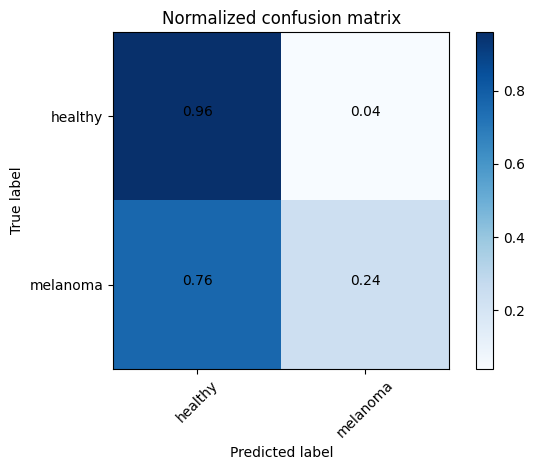

In [39]:
# Fitting Non-linear SVM
print("Fitting Non-linear SVM to the training set")
NLsvm = make_pipeline2(ADASYN(random_state=0),StandardScaler(), SVC(kernel='rbf'))
p_grid_nlsvm = {'svc__C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}
grid_nlsvm = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm,scoring='accuracy', cv=5, return_train_score=True)
grid_nlsvm.fit(X_train, y_train)

# Look for the best estimator (the one with the greatest test accuracy)
best_estimator = grid_nlsvm.best_estimator_
y_pred = best_estimator.predict(X_test)
print("Best training Score: {}".format(grid_nlsvm.best_score_))
print("Best training parameters: {}".format(grid_nlsvm.best_params_))


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,title='Normalized confusion matrix')
plt.show()

**Question** Use the non-linear SVM with the two strategies seen before (different scoring function and/or oversampled data). Do the results change ? Why in your opinion ?

**Answer**
Naturally, the results change when using different scoring functions and oversampled data.

An interesting finding is that when oversampling, using the metric accuracy yields better results than using recall. This does make sense, as this metric is the better when dealing with unbalanced data, when one class has much more data than another. This ceases to be the case after oversampling, and in this case accuracy becomes a more appropriate metric (even if not necessarely the best, as other metrics such as f1 and average precision gave similar results).

**Question** Try to draw a conclusion from the different experiments. Which is the best method ? Which scoring function should you use ? Is it worth it to oversample one of the two classes ?

**Answer** The best method seems to be SVC, with oversampling and methods such as average precision and f1 (both yielded identical results). It is worth noting that using this setup the amount of false positives increased, however this payoff seems to be worth it.

Looking for the best hyperparameter C...
Best training Score: 0.7357142857142858
Best training parameter: 0.001

              precision    recall  f1-score   support

           0       0.88      0.78      0.83       146
           1       0.37      0.56      0.45        34

    accuracy                           0.74       180
   macro avg       0.63      0.67      0.64       180
weighted avg       0.79      0.74      0.76       180

Normalized confusion matrix
[[0.78082192 0.21917808]
 [0.44117647 0.55882353]]


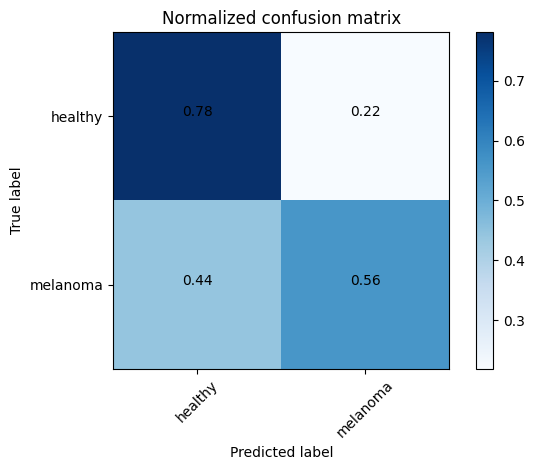

In [50]:
# Looking for the best hyperparameter C
print("Looking for the best hyperparameter C...")
Lsvm = make_pipeline2(ADASYN(random_state=0), StandardScaler(), LinearSVC())
p_grid_lsvm = {'linearsvc__C': [1e-7, 0.5e-6, 1e-6, 0.5e-5, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]}
grid_lsvm = GridSearchCV(estimator=Lsvm, param_grid=p_grid_lsvm,scoring='accuracy', cv=5,return_train_score=True)
grid_lsvm.fit(X_train, y_train)

# Look for the best estimator (the one with the greatest test accuracy)
best_estimator = grid_lsvm.best_estimator_
y_pred = best_estimator.predict(X_test)
print("Best training Score: {}".format(grid_lsvm.best_score_))
print("Best training parameter: {}".format(grid_lsvm.best_params_['linearsvc__C']))
print()

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,title='Normalized confusion matrix')
plt.show()

**OPTIONAL** Another interesting question is: what about the number of features ? Can we reduce the dimensionality ? You could use one of the techniques seen during the previous lectures (i.e. PCA) ...

It was possible to reduce the dimentionality by half without loosing accuracy.

Best training Score: 0.7333333333333334
Best training parameter: 0.001

              precision    recall  f1-score   support

           0       0.88      0.77      0.82       146
           1       0.35      0.53      0.42        34

    accuracy                           0.73       180
   macro avg       0.61      0.65      0.62       180
weighted avg       0.78      0.73      0.75       180

Normalized confusion matrix
[[0.7739726  0.2260274 ]
 [0.47058824 0.52941176]]


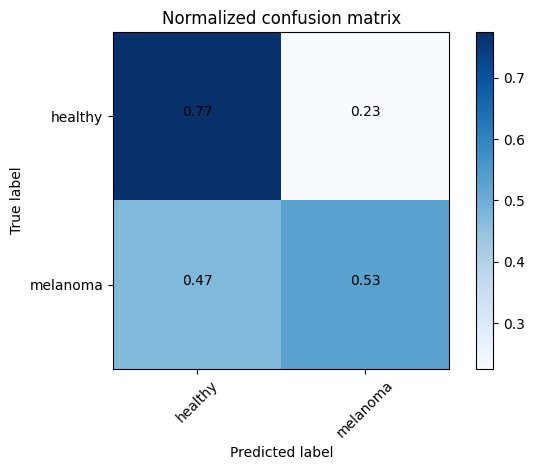

              precision    recall  f1-score   support

           0       0.88      0.77      0.82       146
           1       0.35      0.53      0.42        34

    accuracy                           0.73       180
   macro avg       0.61      0.65      0.62       180
weighted avg       0.78      0.73      0.75       180

Normalized confusion matrix
[[0.7739726  0.2260274 ]
 [0.47058824 0.52941176]]


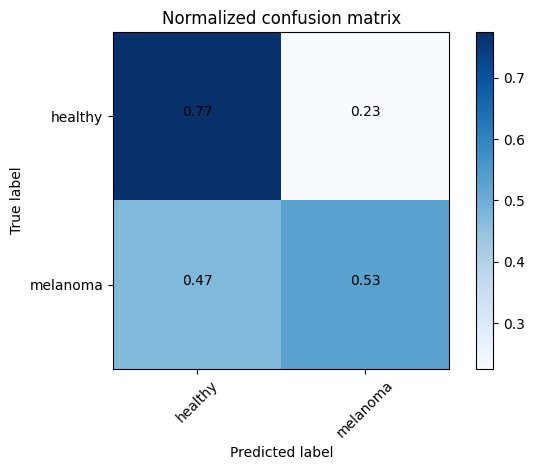

Number of features before PCA: 30
Number of principal components retained after PCA: 15


In [52]:
# Test PCA with a linear SVM

features_before = X_train.shape[1]

Lsvm = make_pipeline2(ADASYN(random_state=0),StandardScaler(), PCA(n_components=0.95), LinearSVC())
p_grid_lsvm = {'linearsvc__C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1]}

grid_lsvm = GridSearchCV(estimator=Lsvm, param_grid=p_grid_lsvm,scoring='accuracy', cv=5,return_train_score=True)
grid_lsvm.fit(X_train, y_train)


best_estimator = grid_lsvm.best_estimator_
y_pred = best_estimator.predict(X_test)
print("Best training Score: {}".format(grid_lsvm.best_score_))
print("Best training parameter: {}".format(grid_lsvm.best_params_['linearsvc__C']))
print()





# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,title='Normalized confusion matrix')
plt.show()



features_after = best_estimator.named_steps['pca'].n_components_



# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,title='Normalized confusion matrix')
plt.show()



print("Number of features before PCA:", features_before)
print("Number of principal components retained after PCA:", features_after)


**OPTIONAL** ... or test the importance of the single features.
The more naive technique would be to test each feature independently in a greedy fashion called sequential forward feature selection. Starting from an empty set and a classification model, you will first add the feature that maximizes a certain criterion (i.e. f1 score). Then, you will iterate this process until a chosen stopping criterion by adding at each iteration only the best feature. Each feature can be added of course only once. You could also use the opposite process by removing at each iteraton the least important feature starting from the entire set of features (i.e. sequential backward feature selection). Implement at least one of these ideas.

In [ ]:
# Implement forward feature selection and/or backward feature selection
# with a linear SVM

XXXXXXXXXX